In [16]:
import os, sys
import pandas as pd 
import numpy as np 
import torch
from torch import nn
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD
import matplotlib.pyplot as plt

# Componentes

## ResidualBlock

In [17]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=(3,3),
                padding='same',
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=(3, 3),
                padding='same',
                bias=False
            ),
            nn.BatchNorm2d(out_channels)
        )
        self.downsample = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=(3, 3),
                padding='same',
                bias=False
            ),
            nn.BatchNorm2d(out_channels)
        )
        self.in_channels = in_channels
        self.out_channels = out_channels

    def residual(self, X):
        if self.in_channels == self.out_channels:
            return X
        else:
            return self.downsample(X)
        
    def forward(self, X):
        return self.layers(X) + self.residual(X)

## ResidualPoolingBlock

In [18]:
class ResidualPoolingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.layers = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(out_channels, out_channels),
            nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
        )

    def forward(self, X):
        return self.layers(X)

## Transformações

In [257]:
class MNISTTransform(nn.Module):
    def __init__(self):
        super().__init__()
        self.transforms = v2.Compose([
            v2.RandomRotation(degrees=15),
            v2.RandomInvert(p=0.2)
        ])

    def forward(self, X):
        return self.transforms(X)

## Sampler

In [258]:
from math import ceil, floor
from torch.utils.data import Sampler

In [328]:
class MNISTSampler(Sampler):
    def __init__(self, label_idxs, group_size=32):
        super().__init__()
        self.label_idxs = label_idxs
        self.group_size = group_size
        self.max_iter = np.min([len(self.label_idxs[l]) for l in self.label_idxs])//self.group_size

    def __iter__(self):
        shuffled_idxs = {
            l: np.random.permutation(self.label_idxs[l]).astype(int) for l in self.label_idxs
        }
        for batch in range(self.max_iter):
            indexes = np.array([], dtype=int)
            for label in shuffled_idxs:
                indexes = np.append(
                    indexes,
                    shuffled_idxs[label][batch*self.group_size:(batch+1)*self.group_size]
                )
            yield indexes

    def __len__(self):
        return self.max_iter

## Loss Functions

### Centroid Triplet Loss

In [440]:
class CentroidTripletLoss(nn.Module):
    def __init__(self, margin, n_classes=10, group_size=32):
        super().__init__()
        self.n_classes = n_classes
        self.group_size = group_size
        self.margin = margin

    def calculate_centroids(self, embeddings):
        centroids = [torch.mean(embeddings[i*self.group_size:(i+1)*self.group_size], dim=0) for i in range(self.n_classes)]
        centroids_tensor = torch.cat([c.unsqueeze(dim=0) for c in centroids], dim=0)
        return centroids_tensor
    
    def calculate_excludent_centroid(self, embeddings, group_idx, excl_rel_idx):
        group_embeddings = embeddings[group_idx*self.group_size:(group_idx+1)*self.group_size]
        num_embeddings = group_embeddings.shape[0] - 1
        return torch.cat([group_embeddings[:excl_rel_idx], group_embeddings[excl_rel_idx+1:]]).sum(axis=0)/num_embeddings

    
    def euclidean_distance(self, tensor_1, tensor_2):
        return torch.cdist(tensor_1.unsqueeze(dim=0), tensor_2.unsqueeze(dim=0)).squeeze()
    
    def centroid_triplet_loss(self, embeddings, centroids):
        accum_loss = torch.tensor(0.0)
        for i in range(embeddings.shape[0]):
            pos_group_idx = i//self.group_size
            rel_idx = i%self.group_size
            mean_neg_dist = torch.tensor(0.0)

            pos_centroid = self.calculate_excludent_centroid(embeddings, pos_group_idx, rel_idx)
            pos_dist = self.euclidean_distance(embeddings[i], pos_centroid)
            for j in range(self.n_classes):
                if j != pos_group_idx:
                    neg_group_centroid = centroids[j]
                    mean_neg_dist += self.euclidean_distance(embeddings[i], neg_group_centroid)
            mean_neg_dist /= (self.n_classes-1)
            # Para efeito prático, é calculada a média dos centroid triplet loss do embedding
            # em relação a cada grupo negativo
            accum_loss += torch.max(pos_dist - mean_neg_dist + self.margin, torch.tensor(0.0))

        return accum_loss/(self.n_classes*self.group_size)
    
    def forward(self, embeddings):
        centroids = self.calculate_centroids(embeddings)
        return self.centroid_triplet_loss(embeddings, centroids)

### Complete Loss

In [400]:
class CompleteLoss(nn.Module):
    def __init__(self, crossent_w=1):
        super().__init__()
        self.cross_ent_loss_func = nn.CrossEntropyLoss()
        self.ce_w = crossent_w

    def cross_entropy_loss(self, logits, targets):
        return self.cross_ent_loss_func(logits, targets)

    def forward(self, logits, targets, interm_loss):
        ce_loss = self.cross_ent_loss_func(logits, targets)
        comp_loss = interm_loss + self.ce_w*ce_loss
        return comp_loss

## Dataset

In [485]:
from torch.nn.functional import one_hot

In [504]:
class MNISTDataset(Dataset):
    def __init__(self, data: pd.DataFrame):
        self.transforms = MNISTTransform()
        self.format_data(data)
        self.group_indexes = {
            l: np.array(data.groupby("label").groups[l], dtype=int) for l in data.groupby("label").groups
        }

    def get_tensor(self, row):
        matrix = np.array([row[28*i:28*(i+1)] for i in range(28)])
        return torch.tensor(matrix, dtype=torch.float)
        
    def format_data(self, data: pd.DataFrame):
        one_hot_targets = one_hot(torch.tensor(data.label.to_numpy(), dtype=torch.int64), num_classes=10)
        self.targets = one_hot_targets
        images = data.drop(columns="label")
        images_idx = data.index
        images_array = images.to_numpy()
        formatted = np.fromiter((self.get_tensor(arr) for arr in images_array), dtype=object)
        formatted_series = pd.Series(formatted, index=images_idx, name="Images")
        self.images = formatted_series

    def get_sampler(self, group_size=32):
        return MNISTSampler(self.group_indexes, group_size)

    def __getitem__(self, idx):
        X = self.transforms(self.images.iloc[idx].unsqueeze(dim=0))
        y = self.targets[idx]
        return (X, y)
    
    def __len__(self):
        return self.targets.shape[0]

## CNN

In [487]:
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import MultiStepLR

In [521]:
class MNISTCNN(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=4,
                kernel_size=(3, 3),
                padding='same',
                bias=False
            ),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            ResidualPoolingBlock(4, 16),
            ResidualPoolingBlock(16, 32),
            nn.AvgPool2d(kernel_size=(7, 7))
        )
        self.classifier = nn.Sequential(
            nn.Linear(
                in_features=32,
                out_features=16,
            ),
            nn.ReLU(),
            nn.Linear(
                in_features=16,
                out_features=10
            )
        )

        self.CTL = None
        self.comp_loss = None

        self.loss_hist = {
            "Train": [],
            "Val": []
        }

    def forward(self, X):
        return self.layers(X.to(dtype=torch.float)).squeeze()

    def fit(
            self,
            tr_dataloader,
            validate=False,
            val_dataloader=None,
            epochs=120,
            lr=0.001,
            margin=0.3,
            group_size=32,
            crossent_w=1
    ):
        self.optim = torch.optim.SGD(self.parameters(), lr)
        self.CTL = CentroidTripletLoss(margin, group_size=group_size)
        self.comp_loss = CompleteLoss(crossent_w=crossent_w)
        self.scheduler = MultiStepLR(
            optimizer=self.optim,
            milestones=[40, 70],
            gamma=0.1
        )

        epoch_iterator = tqdm(
            range(epochs),
            desc="Época"
        )

        for epoch in epoch_iterator:
            epoch_train_loss = 0
            epoch_val_loss = 0
            batch_iterator = tqdm(
                enumerate(tr_dataloader),
                desc="Batch"
            )
            for batch, (X, y) in batch_iterator:
                self.train()
                embeddings = self(X)
                ctl = self.CTL(embeddings)
                logits = self.classifier(embeddings)
                batch_loss = self.comp_loss(logits, y.to(dtype=torch.int64), ctl)
                epoch_train_loss += batch_loss.item()
                self.optim.zero_grad()
                batch_loss.backward()
                self.optim.step()
                self.scheduler.step()
                self.eval()

            epoch_train_loss /= len(tr_dataloader.batch_sampler)
            self.loss_hist["Train"].append(epoch_train_loss)

            if validate:
                val_batch_iterator = tqdm(
                    iterable=enumerate(val_dataloader),
                    desc="Validation Batch"
                )
                for batch, (X, y) in val_batch_iterator:
                    val_embeddings = self(X)
                    ctl = self.CTL(val_embeddings)
                    logits = self.classifier(val_embeddings)
                    val_batch_loss = self.comp_loss(logits, y, ctl)
                    epoch_val_loss += val_batch_loss.item()
                epoch_val_loss /= len(val_dataloader.batch_sampler)
                self.loss_hist["Val"].append(epoch_val_loss)

    def plot_loss_history(self):
        epoch_indexes = np.arange(len(self.loss_hist["Train"]))
        plt.plot(epoch_indexes, self.loss_hist["Train"], c='b', label="Treino")
        if len(self.loss_hist["Val"]) > 0:
            plt.plot(epoch_indexes, self.loss_hist["Val"], c='r', label="Validação")

        plt.legend(title="Loss", loc='upper left', bbox_to_anchor=(1, 1))
        plt.title("Progressão das perdas por época")
        plt.xlabel("Época")
        plt.ylabel("Perda")
        plt.show()


# Testes

## ResidualBlock

In [489]:
random_input = torch.rand(size=(1, 1, 28, 28), dtype=torch.float)
res_block = ResidualBlock(1, 4)
res_block(random_input).shape

torch.Size([1, 4, 28, 28])

## ResidualPoolingBlock

In [490]:
res_pooling = ResidualPoolingBlock(1, 4)
res_pooling(random_input).shape

torch.Size([1, 4, 14, 14])

## Dataset, Sampler & DataLoader

### Dataset

In [491]:
data_path = os.path.join('..', 'data', 'train.csv')
data = pd.read_csv(data_path)

In [505]:
dataset = MNISTDataset(data)

In [506]:
dataset.images[0].shape

torch.Size([28, 28])

In [509]:
len(dataset)

42000

In [510]:
dataset.images.shape

(42000,)

In [515]:
dataset.targets.shape

torch.Size([42000, 10])

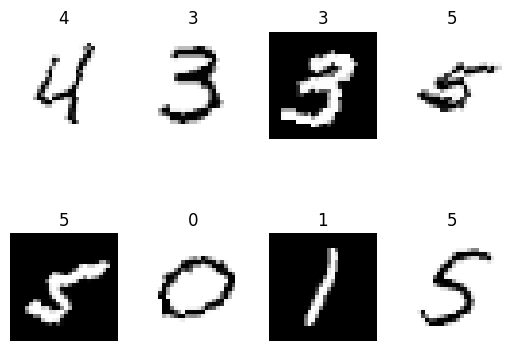

In [513]:
fig, axes = plt.subplots(nrows=2, ncols=4)
for line in axes:
    for ax in line:
        random_idx = np.random.randint(0, len(dataset))
        random_img, random_img_label = dataset[random_idx]
        ax.imshow(random_img.squeeze(dim=0), cmap='Grays')
        ax.axis("off")
        ax.set_title(str(random_img_label.argmax().item()))
plt.show()

In [514]:
type(dataset.group_indexes[0][0])

numpy.int64

### Sampler

In [ ]:
sampler = dataset.get_sampler()

In [ ]:
len(sampler)

118

In [ ]:
for batch, idxs in enumerate(sampler):
    print(f"Largura do batch {batch}: {len(idxs)}")

Largura do batch 0: 320
Largura do batch 1: 320
Largura do batch 2: 320
Largura do batch 3: 320
Largura do batch 4: 320
Largura do batch 5: 320
Largura do batch 6: 320
Largura do batch 7: 320
Largura do batch 8: 320
Largura do batch 9: 320
Largura do batch 10: 320
Largura do batch 11: 320
Largura do batch 12: 320
Largura do batch 13: 320
Largura do batch 14: 320
Largura do batch 15: 320
Largura do batch 16: 320
Largura do batch 17: 320
Largura do batch 18: 320
Largura do batch 19: 320
Largura do batch 20: 320
Largura do batch 21: 320
Largura do batch 22: 320
Largura do batch 23: 320
Largura do batch 24: 320
Largura do batch 25: 320
Largura do batch 26: 320
Largura do batch 27: 320
Largura do batch 28: 320
Largura do batch 29: 320
Largura do batch 30: 320
Largura do batch 31: 320
Largura do batch 32: 320
Largura do batch 33: 320
Largura do batch 34: 320
Largura do batch 35: 320
Largura do batch 36: 320
Largura do batch 37: 320
Largura do batch 38: 320
Largura do batch 39: 320
Largura do

### DataLoader

In [ ]:
dataloader = DataLoader(dataset=dataset, batch_sampler=sampler)

In [ ]:
for batch, (X, y) in enumerate(dataloader):
    print(f"Dimensões do batch {batch}: {X.shape}")

Dimensões do batch 0: torch.Size([320, 1, 28, 28])
Dimensões do batch 1: torch.Size([320, 1, 28, 28])
Dimensões do batch 2: torch.Size([320, 1, 28, 28])
Dimensões do batch 3: torch.Size([320, 1, 28, 28])
Dimensões do batch 4: torch.Size([320, 1, 28, 28])
Dimensões do batch 5: torch.Size([320, 1, 28, 28])
Dimensões do batch 6: torch.Size([320, 1, 28, 28])
Dimensões do batch 7: torch.Size([320, 1, 28, 28])
Dimensões do batch 8: torch.Size([320, 1, 28, 28])
Dimensões do batch 9: torch.Size([320, 1, 28, 28])
Dimensões do batch 10: torch.Size([320, 1, 28, 28])
Dimensões do batch 11: torch.Size([320, 1, 28, 28])
Dimensões do batch 12: torch.Size([320, 1, 28, 28])
Dimensões do batch 13: torch.Size([320, 1, 28, 28])
Dimensões do batch 14: torch.Size([320, 1, 28, 28])
Dimensões do batch 15: torch.Size([320, 1, 28, 28])
Dimensões do batch 16: torch.Size([320, 1, 28, 28])
Dimensões do batch 17: torch.Size([320, 1, 28, 28])
Dimensões do batch 18: torch.Size([320, 1, 28, 28])
Dimensões do batch 19:

## Funções de custo

In [ ]:
ctl = CentroidTripletLoss(margin=0.3, group_size=3, n_classes=4)
fake_embeddings = torch.rand(size=(12, 3))

In [ ]:
ctl.calculate_centroids(fake_embeddings)

tensor([[0.4855, 0.3393, 0.5719],
        [0.4524, 0.1443, 0.3194],
        [0.6217, 0.5417, 0.8067],
        [0.4258, 0.0893, 0.3607]])

In [ ]:
ctl(fake_embeddings)

tensor(0.3374)

In [ ]:
fake_logits = torch.rand(size=(12, 4))
fake_targets = torch.rand_like(fake_logits)
compl_loss = CompleteLoss()

In [ ]:
compl_loss(fake_logits, fake_targets, ctl(fake_embeddings))

tensor(3.2630)

## CNN

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
data.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [ ]:
X_complete = data.drop(columns=["label"])
y_complete = data.label
X_tr, X_val, y_tr, y_val = train_test_split(X_complete, y_complete, test_size=0.1)
train_data = pd.concat([X_tr, y_tr], axis=1, join='outer')
val_data = pd.concat([X_val, y_val], axis=1, join='outer')

train_data.shape, val_data.shape

((37800, 785), (4200, 785))

In [ ]:
train_dataset = MNISTDataset(train_data)
train_dataloader = DataLoader(train_dataset, batch_sampler=train_dataset.get_sampler(group_size=32))
val_dataset = MNISTDataset(val_data)
val_dataloader = DataLoader(val_dataset, batch_sampler=val_dataset.get_sampler(group_size=32))

In [ ]:
len(train_dataset), len(val_dataset)

(37800, 4200)

In [ ]:
len(train_dataloader), len(val_dataloader)

(106, 11)

In [ ]:
for batch, (X, y) in enumerate(train_dataloader):
    print(batch)

IndexError: single positional indexer is out-of-bounds

In [523]:
cnn = MNISTCNN()

In [524]:
cnn.fit(
    tr_dataloader=dataloader,
    validate=False,
    val_dataloader=val_dataloader,
    epochs=5
)

Época:   0%|          | 0/5 [00:00<?, ?it/s]

Batch: 0it [00:00, ?it/s]

Batch: 0it [00:00, ?it/s]

Batch: 0it [00:00, ?it/s]

Batch: 0it [00:00, ?it/s]

Batch: 0it [00:00, ?it/s]

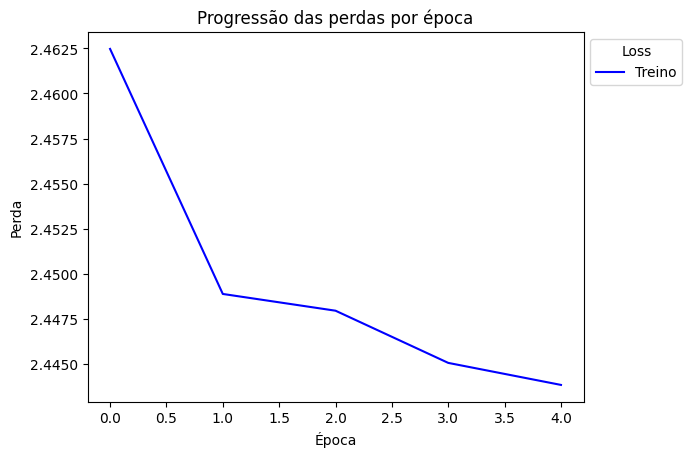

In [525]:
cnn.plot_loss_history()

In [ ]:
cnn.fit(
    tr_dataloader=train_dataloader,
    validate=True,
    val_dataloader=val_dataloader
)

Época:   0%|          | 0/120 [00:00<?, ?it/s]

Batch: 0it [00:00, ?it/s]

IndexError: single positional indexer is out-of-bounds